In [2]:
# import shutil
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from astropy.io import fits
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from numpy.polynomial.chebyshev import chebfit, chebval
import astropy
from astropy.time import Time

import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.simplefilter('ignore', category=AstropyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


print('Numpy version ', np.__version__)
print('Pandas version ',pd.__version__)
print('Astropy version ', astropy.__version__)


Numpy version  1.21.5
Pandas version  1.4.4
Astropy version  5.1


In [3]:
def normal_(wave, I, point, n):
    dff = wave-point
    order = list(abs(dff)).index(min(abs(dff)))
    n = int(n)
    value = np.nanmedian(I[order-n:order:n])
    return value

def normal_f(wave, I, point):
    dff = wave-point
    order = list(abs(dff)).index(min(abs(dff)))
    value = np.nanmedian(I[order])
    return value

## Process the 2001 CC21 spectrum
Here, we show how we process the 2001 CC21 spectrum taken on 2023 Feb 06, as the example.<br />
We exclude the images taken during the weather is not good (i.e., thick cloud or fog)

### Plot all

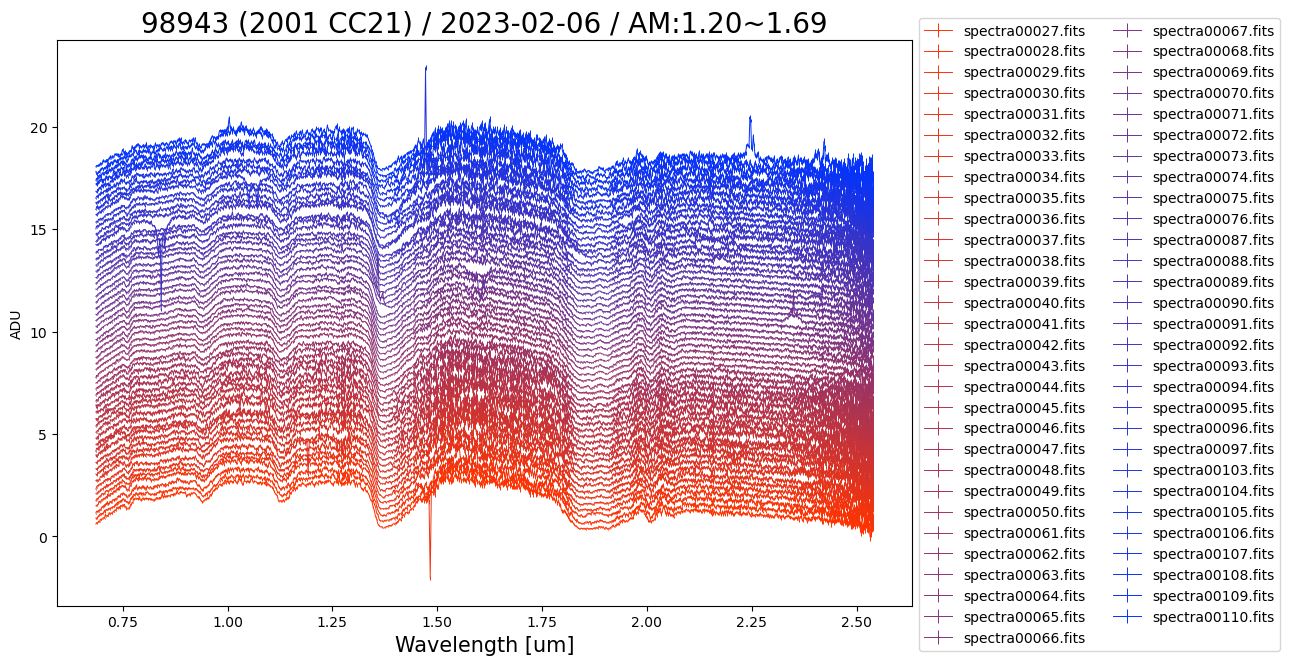

In [4]:
##1. Bring the asteroid spectra
obj = '2001 CC21'
dic_tar = os.path.join('/Users/judy/Dropbox/Research/SpeX/230206/proc/98943(2001CC21)')
#Directory where the only 1D-solar analog spectra in FITS format are saved
file_tar = glob.glob(os.path.join(dic_tar,'*.fits'))
file_tar = sorted(file_tar)
com_spec = pd.DataFrame({'filename':[],'wave':[],'spec':[],'err':[]})
fig,ax = plt.subplots(1,1,figsize=(13,7))
for n,file in enumerate(file_tar):
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    filename = file.split('/')[-1]
    com_spec = com_spec.append({'filename':filename,
                                   'wave':data[0],
                                   'spec':np.array(data[1]),
                                   'err':data[2],
                                   'AIRMASS':header['TCS_AM']},
                                  ignore_index=True)
    r = 1/len(file_tar)*(len(file_tar)-n)
    b = 1/len(file_tar)*(n)
    color=(r, 0.2, b)
    OBJECT = header['OBJECT']
        
    ax.errorbar(data[0],data[1]/np.nanmedian(data[1])+0.3*(n+1),yerr=data[2]/np.nanmedian(data[1]),color=color,
                lw=0.7,label=filename)
    ax.set_xlabel('Wavelength [um]',fontsize=15)
    ax.set_ylabel('ADU')
ax.set_title(OBJECT+' / {2} / AM:{0:.2f}~{1:.2f}'.format(min(com_spec['AIRMASS'].values),
                                                         max(com_spec['AIRMASS'].values),
                                                         header['DATE_OBS'])
             ,fontsize=20)
ax.legend(fontsize=10,bbox_to_anchor=(1.0, 1.05),ncol=2)
plt.tight_layout()

### Devide the asteroidal spectra by the solar analog

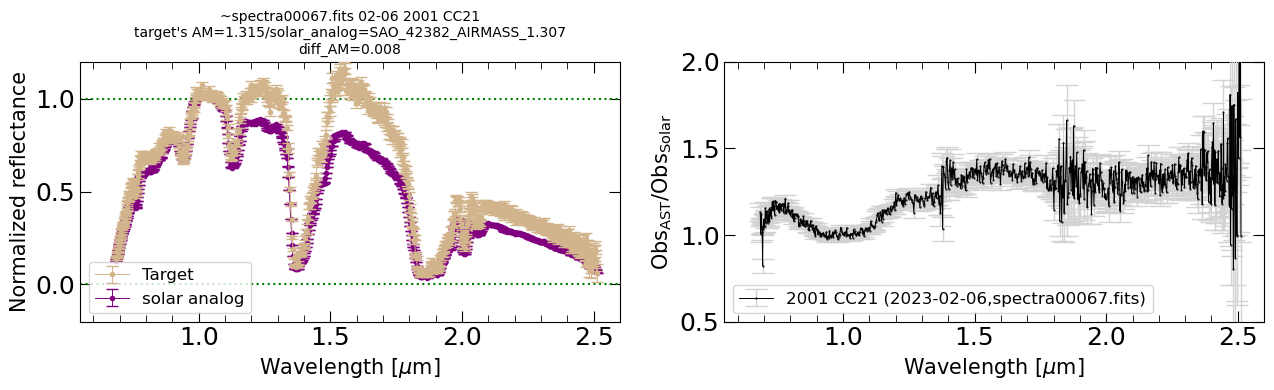

In [6]:
obj = '2001 CC21'
#Bring the target spectra
dic_obj = os.path.join('/Users/judy/Dropbox/Research/SpeX/230206/proc/98943(2001CC21)')
file_obj = glob.glob(os.path.join(dic_obj,'*.fits'))
file_obj = sorted(file_obj)
com_spec = pd.DataFrame({'filename':[],'wave':[],'spec':[],'err':[]})

#Bring the solar analog spectra
#Made by the another script whose name is "Combind_solar_analog_spec.ipynb"
sol_dic = os.path.join('/Users/judy/Dropbox/Research/SpeX/230206/proc/')
sol_dic = glob.glob(os.path.join(sol_dic,'com_SAO*.fits'))


for n,file in enumerate(file_obj[30:31]): #Show one spectrum as a example
    ### OBJECT     
    hdul = fits.open(file)[0]
    header = hdul.header
    data = hdul.data
    wave_ast = data[0][:-15]
    I_ast = data[1][:-15]
    err_ast = data[2][:-15]
    filename = file.split('/')[-1]
    com_spec = com_spec.append({'filename':filename,'wave':data[0],
                                'spec':np.array(data[1]),'err':data[2],
                                'AIRMASS':header['TCS_AM']},
                               ignore_index=True)  
    r = 1/len(file_obj)*(len(file_obj)-n)
    b = 1/len(file_obj)*(n)
    color=(r, 0.2, b)
    OBJECT = header['OBJECT']
    AIRMASS = header['TCS_AM']
            
    #Bring solar analog===============================================
    sol_am = []
    sol_file = []
    for s in sol_dic:
        am = s.split('_AIRMASS_')[-1].split('.fits')[0]
        am = float(am)
        sol_am.append(am)
    sol_am = np.array(sol_am)
    diff_sol_am = abs(sol_am - AIRMASS)
    order = np.where(diff_sol_am==min(diff_sol_am))[0][0]
    solar_fit = sol_dic[order]
    
    solar_hdul = fits.open(solar_fit)[0]
    sol = solar_hdul.data
    solar_wave = sol[0][:-15]
    solar_data = sol[1][:-15]
    solar_err = sol[2][:-15]
    
    ast_n = normal_f(wave_ast,I_ast,1.05)
    sol_n = normal_f(wave_ast,solar_data,1.05)
    
    fig,ax1 = plt.subplots(1,2,figsize=(13,4))   
    
    ax1[0].errorbar(wave_ast,I_ast/ast_n,yerr=err_ast/ast_n,marker='.',
                label=r'Target',color='tan',capsize=4,lw=0.7,zorder=10)
    
    ax1[0].errorbar(solar_wave,solar_data/sol_n,yerr=solar_err/sol_n,marker='.',
                label=r'solar analog',color='purple',capsize=4,lw=0.7)
    
    ax1[0].set_ylim(-0.2,1.2)
    ax1[0].set_ylabel('Normalized reflectance',fontsize=15)
    ax1[0].axhline(1,ls=':',color='g')
    ax1[0].axhline(0,ls=':',color='g')
    
    
    #Dividing asteroid/solar analog
    ast_obs = I_ast/solar_data
    err_obs = np.sqrt((1/solar_data*err_ast)**2+
                      (I_ast/solar_data**2*solar_err)**2)    
    
    nor = normal_f(wave_ast,ast_obs,1.05)
    ax1[1].errorbar(wave_ast, ast_obs/nor,yerr=err_obs/nor,
                    marker='.',ms=1,elinewidth=1,ecolor='lightgray',
                    label='2001 CC21 ({1},{0})'.format(file.split('/')[-1],header['DATE_OBS']),
                    color='k',capsize=8,lw=0.7,zorder=30)
    for i in [0,1]:
        ax1[i].tick_params(axis='both',labelsize=18)
        ax1[i].tick_params(axis = 'both', which='minor', length=5)
        ax1[i].tick_params(axis ='both',which='both', direction='in')
        ax1[i].tick_params(axis ='both',which='major', length=8)
        ax1[i].yaxis.set_ticks_position('both')
        ax1[i].xaxis.set_ticks_position('both')
        ax1[i].set_facecolor('xkcd:white')
        ax1[i].set_xlim(0.55,2.6)
        ax1[i].xaxis.set_major_locator(MultipleLocator(0.5))
        ax1[i].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax1[i].set_xlabel(r'Wavelength [$\mu$m]',fontsize=15)
        ax1[i].legend(loc=3,fontsize=12)
    ax1[1].set_ylabel(r'Obs$_\mathrm{AST}$/Obs$_\mathrm{Solar}$',fontsize=15)
    ax1[0].set_title('~'+file.split('/')[-1]+' '+header['DATE_OBS'][5:]+' '+
                  '2001 CC21'+'\n'+"target's AM={0:.3f}/solar_analog={1}\ndiff_AM={2:.3f}".format(header['TCS_AM'],
                                                    solar_fit.split('/')[-1][4:-5],min(diff_sol_am)),
                 fontsize=10)
    
    ax1[1].set_ylim(0.5,2)
plt.tight_layout()    
    

### For individual spectrum, how we reject the outliers for the individual spectrum
We did the same process for all spectra. The uncertainty is shown by a gray error bar. 


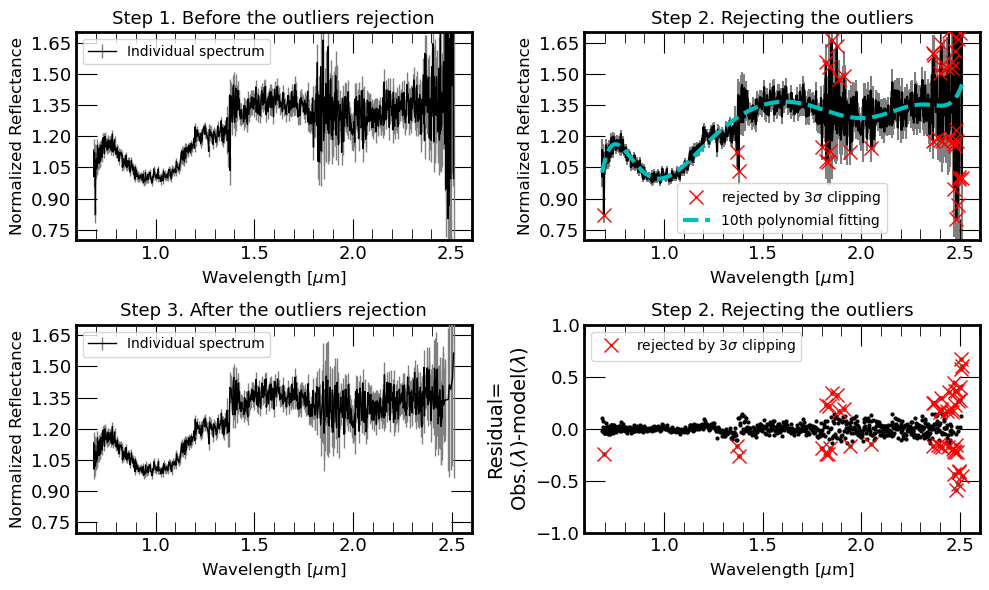

In [17]:
fig,ax = plt.subplots(2,2,figsize=(10,6))
plt.rcParams['axes.linewidth'] = 2

nor = normal_f(wave_ast,ast_obs,1.05) #For the normalizationn
ax[0,0].errorbar(wave_ast, ast_obs/nor, yerr=err_obs/nor,lw=1,
            color='k',ecolor='gray',label=r'Individual spectrum') 
ax[0,0].set_title('Step 1. Before the outliers rejection',fontsize=13)

I_ast_obs = ast_obs/nor
Err_ast_obs = err_obs/nor
## reject
order_fitting = 10
coeff_re3 = chebfit(wave_ast,
                    I_ast_obs,
                    deg=order_fitting)
y3 = chebval(wave_ast,coeff_re3)
resid3 = I_ast_obs - y3
resid_mask3 = sigma_clip(resid3, sigma=3, maxiters=10).mask


coeff_re4 = chebfit(wave_ast[~resid_mask3],
                    I_ast_obs[~resid_mask3], 
                    deg=order_fitting)
y4 = chebval(wave_ast,coeff_re4)
resid4 = I_ast_obs - y4
resid_mask4 = sigma_clip(resid4, sigma=3, maxiters=10).mask

ax[0,1].errorbar(wave_ast, I_ast_obs,yerr=Err_ast_obs,
               color='k',ecolor='gray', zorder=1) 
ax[0,1].errorbar(wave_ast[resid_mask4], I_ast_obs[resid_mask4], 
               marker='x', ls='', color='r',ms=10, 
               label=r'rejected by 3$\sigma$ clipping',zorder=31)
ax[0,1].errorbar(wave_ast,y4,color='c',ls='--',lw=3,
           label="{0}th polynomial fitting".format(order_fitting),zorder=32)
ax[0,1].set_title('Step 2. Rejecting the outliers',fontsize=13)

ax[1,1].plot(wave_ast, resid4, marker='o', ls='',ms=2,color='k')
ax[1,1].errorbar(wave_ast[resid_mask4], resid4[resid_mask4], 
            marker='x', ls='', 
             color='r',ms=10, label=r'rejected by 3$\sigma$ clipping',zorder=31)
ax[1,1].set_title('Step 2. Rejecting the outliers',fontsize=13)

ax[1,0].set_title('Step 3. After the outliers rejection',fontsize=13)
ax[1,0].errorbar(wave_ast[~resid_mask4], I_ast_obs[~resid_mask4],lw=1,
                 yerr=Err_ast_obs[~resid_mask4], 
                 color='k',ecolor='gray',label='Individual spectrum',
                 zorder=1000) 



for row in [0,1]:
    for col in [0,1]:
        ax[row,col].tick_params(axis='both',labelsize=13)
        ax[row,col].xaxis.set_major_locator(MultipleLocator(0.5))
        ax[row,col].xaxis.set_minor_locator(MultipleLocator(0.1))
        ax[row,col].yaxis.set_major_locator(MultipleLocator(0.15))
        ax[row,col].tick_params(axis = 'both', which='minor', length=8)
        ax[row,col].tick_params(axis ='both',which='both', direction='in')
        ax[row,col].tick_params(axis ='both',which='major', length=15)
        ax[row,col].yaxis.set_ticks_position('both')
        ax[row,col].xaxis.set_ticks_position('both')
        ax[row,col].set_ylim(0.70,1.7)
        ax[row,col].set_xlabel(r'Wavelength [$\mu$m]',fontsize=12)
        ax[row,col].set_ylabel('Normalized Reflectance',fontsize=12)
        ax[row,col].legend(fontsize=10)
    
ax[1,1].set_ylim(-1,1)
ax[1,1].set_ylabel('Residual=\n'+r'Obs.($\lambda$)-model($\lambda$)',fontsize=14)
ax[1,1].yaxis.set_major_locator(MultipleLocator(0.5))
plt.tight_layout()
plt.rcParams['axes.linewidth'] = 1



### Median combine

Since there is no significant difference between Feb 05 and 06's spectra, .<br />
we combine all 86 spectra together.
The value at each pixel (i.e., wavelength) is given by the median,.<br />
and their uncertainty is given by the standard error around the median (MAD/$\sqrt(N)$) of the pixels.<br />
Here, MAD is the median absolute deviation given by 1.482 × med(|I($\lambda$) − med(I($\lambda$))|), and N= number of spectra. .<br />
We followed the SpexTool manual, section 2.8 Combination Statistics (page 16).

In [11]:
# #Bring all individual spectra after the 3-sigma outlier rejected
from tqdm import tqdm, notebook
dic = os.path.join('/Users/judy/Dropbox/Research/SpeX/230206/proc/98943(2001CC21)')
file_list = glob.glob(os.path.join(dic,'*_*(fin).csv'))
file_list = sorted(file_list)

dic = os.path.join('/Users/judy/Dropbox/Research/SpeX/230205/proc/98943(2001CC21)')
file_list2 = glob.glob(os.path.join(dic,'*_*(fin).csv'))
file_list2 = sorted(file_list2)

FILE_LIST =  file_list+ file_list2

combine = pd.DataFrame({'wave':[],'I':[],'err':[]})
w = pd.read_csv(FILE_LIST[0])['wave'].values
med_I, err_I = [], []

for w_i in tqdm(w):
    w_i = np.around(w_i,4)
    w_list, err_list, flag_list = [], [], []
    for file in FILE_LIST:
        temp = pd.read_csv(file)
        if '230205' in file:
            w_i = temp['wave'].values[list(abs(temp['wave'].values-w_i)).index(min(abs(temp['wave'].values-w_i)))]
            w_i = np.around(w_i,4)
        temp = temp.round({'wave':4})
        I = temp[temp['wave'] == w_i]['I'].values[0]
        errr = temp[temp['wave'] == w_i]['err'].values[0]
        flagg = temp[temp['wave']== w_i]['flag'].values[0]
        w_list.append(I)
        err_list.append(errr)
        flag_list.append(flagg)
    ffff = np.array(flag_list).astype(bool)
    w_list = np.array(w_list)
    median_value = np.nanmedian(w_list[~ffff])
    sub_array = abs(w_list[~ffff] - median_value)
    MAD = 1.482*np.median(sub_array)
    median_err = MAD/np.sqrt(len(w_list[~ffff]))
    med_I.append(median_value)
    err_I.append(median_err)
    
combine['wave'] = w
combine['I'] = med_I
combine['err'] = err_I

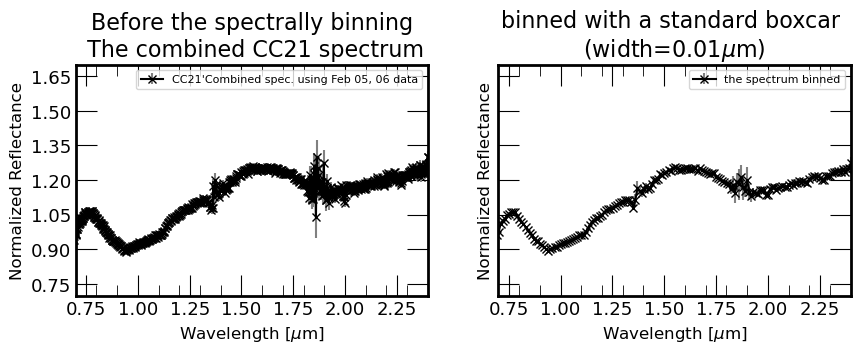

In [16]:
fig,ax = plt.subplots(1,2,figsize=(10,3),sharey=True)
plt.rcParams['axes.linewidth'] = 2

CC21_all = combine[combine['err']<0.1]
ax[0].errorbar(CC21_all['wave'], CC21_all['I'], yerr=CC21_all['err'],marker='x',
            color='k',ecolor='gray',label=r"CC21'Combined spec. using Feb 05, 06 data") 
Binsize=0.01
bin_df = pd.DataFrame({'wave':[],'I':[],'err':[]})
for w_i in np.arange(CC21_all['wave'].values[0]+Binsize/2, CC21_all['wave'].values[-1],Binsize):
    start_w = w_i-Binsize/2
    end_w = w_i+Binsize/2
    spec_bin = CC21_all[CC21_all['wave']>start_w]
    spec_bin = spec_bin[spec_bin['wave']<end_w]
    avg_I = np.average(spec_bin['I'].values)
    err_I = np.sqrt(np.sum((spec_bin['err'].values)**2))/np.sqrt(len(spec_bin))
    bin_df = bin_df.append({'wave':w_i,
                          'I':avg_I,
                          'err':err_I},ignore_index=True)

ax[1].errorbar(bin_df['wave'], bin_df['I'], yerr=bin_df['err'],marker='x',
            color='k',ecolor='gray',label=r'the spectrum binned') 
ax[1].set_title('binned with a standard boxcar \n'+r'(width={0:.2f}$\mu$m)'.format(Binsize),fontsize=16)
ax[0].set_title('Before the spectrally binning\n The combined CC21 spectrum',fontsize=16)
    
for i in [0,1]:
    ax[i].tick_params(axis='both',labelsize=13)
    ax[i].xaxis.set_major_locator(MultipleLocator(0.25))
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.1))
    ax[i].yaxis.set_major_locator(MultipleLocator(0.15))
    ax[i].tick_params(axis = 'both', which='minor', length=8)
    ax[i].tick_params(axis ='both',which='both', direction='in')
    ax[i].tick_params(axis ='both',which='major', length=15)
    ax[i].yaxis.set_ticks_position('both')
    ax[i].xaxis.set_ticks_position('both')
    ax[i].set_ylim(0.70,1.7)
    ax[i].set_xlim(0.70,2.4)
    ax[i].set_xlabel(r'Wavelength [$\mu$m]',fontsize=12)
    ax[i].set_ylabel('Normalized Reflectance',fontsize=12)
    ax[i].legend(fontsize=8)    